### Base settings

In [1]:
%load_ext autoreload
%autoreload 2

import time
from pprint import pprint
from pathlib import Path
from collections import OrderedDict
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import torch
import torch.nn as nn
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [2]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar10.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [5]:
# frequently used variables
model_name = config.model.name
patch_size = config.model.patch_size
summary = config.summary

# log directories
log_root = Path('./logs') / model_name / summary
checkpoint_path = log_root / 'checkpoints'

In [6]:
# initialize ViT model and load pretrained weights
from ood_with_vit.models.vit import ViT

n_class = config.dataset.n_class
if config.model.pretrained:
    model = torch.hub.load(
        repo_or_dir=config.model.repo,
        model=config.model.pretrained_model,
        pretrained=False,
    )
    model.head = nn.Linear(model.head.in_features, n_class)
else:
    model = ViT(
        image_size=config.model.img_size,
        patch_size=config.model.patch_size,
        num_classes=n_class,
        dim=config.model.dim_head,
        depth=config.model.depth,
        heads=config.model.n_heads,
        mlp_dim=config.model.dim_mlp,
        dropout=config.model.dropout,
        emb_dropout=config.model.emb_dropout,
        visualize=True,
    )

model = model.to(device=device)
print(model)

checkpoint = torch.load(checkpoint_path / f'{summary}_best.pt')

state_dict = checkpoint['model_state_dict']
trimmed_keys = []
for key in state_dict.keys():
    # remove prefix 'module.' for each key (in case of DataParallel)
    trimmed_keys.append(key[7:])
trimmed_state_dict = OrderedDict(list(zip(trimmed_keys, state_dict.values())))

model.load_state_dict(trimmed_state_dict)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((192,), ep

<All keys matched successfully>

In [8]:
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader, Dataset

dataset_mean, dataset_std = config.dataset.mean, config.dataset.std
dataset_root = config.dataset.root
img_size = config.model.img_size

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      

cifar10 = CIFAR10(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
id_test_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)

cifar100 = CIFAR100(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
ood_test_dataloader = DataLoader(
    dataset=cifar100, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)

print(cifar10.class_to_idx)
print(cifar100.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, '

### Utility

In [9]:
# set seeds
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

### Visualize features

In [15]:
# gather penultimate features
from ood_with_vit.utils import compute_penultimate_features

num_samples = 20
num_class = 10

print('processing in-distribution samples...')
X_in, y_in = [], []
cls_indices = random.sample(range(len(cifar10.classes)), num_class)
for cls_idx in cls_indices:
    img_indices = np.where(np.array(cifar10.targets) == cls_idx)[0]
    img_indices = random.sample(list(img_indices), num_samples)
    for i in tqdm(img_indices):
        img, _ = cifar10[i]
        img = img.to(device)
        penultimate_features = compute_penultimate_features(config, model, img.unsqueeze(0))
        X_in.append(penultimate_features.squeeze().numpy())
        y_in.append((cls_idx, cifar10.classes[cls_idx]))

print('processing out-of-distribution samples...')
X_out, y_out = [], []
cls_indices = random.sample(range(len(cifar100.classes)), num_class)
for cls_idx in cls_indices:
    img_indices = np.where(np.array(cifar100.targets) == cls_idx)[0]
    img_indices = random.sample(list(img_indices), num_samples)
    for i in tqdm(img_indices):
        img, _ = cifar100[i]
        img = img.to(device)
        penultimate_features = compute_penultimate_features(config, model, img.unsqueeze(0))
        X_out.append(penultimate_features.squeeze().numpy())
        y_out.append((cls_idx, cifar100.classes[cls_idx]))

 20%|██        | 4/20 [00:00<00:00, 33.90it/s]

processing in-distribution samples...


 15%|█▌        | 3/20 [00:00<00:00, 29.64it/s]

processing out-of-distribution samples...


100%|██████████| 20/20 [00:00<00:00, 34.47it/s]


#### Feature visualization by T-SNE

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_in)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_in)
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    title='ImageNet pretrained ViT CIFAR10 T-SNE',
)
fig.show()

In [20]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_out)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_out)
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    title='ImageNet pretrained ViT CIFAR100 T-SNE',
)
fig.show()

#### Feature visualization by PCA

In [21]:
from sklearn.decomposition import PCA

pca = PCA()
components = pca.fit_transform(X_in)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_in)
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    title='ImageNet pretrained ViT CIFAR9 PCA',
)
fig.show()

In [22]:
pca = PCA()
components = pca.fit_transform(X_out)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_out)
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    title='ImageNet pretrained ViT CIFAR9 PCA',
)
fig.show()

### OOD detection baselines

In [23]:
# utility functions

from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
    
    
def plot_precision_recall_curve(precision, recall):
    plt.plot(recall, precision, color='red', label='ROC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    
def compute_ood_scores(
    metric,
    id_dataloader,
    ood_dataloader,
):
    test_y, ood_scores = [], []
    print('processing in-distribution samples...')
    id_ood_scores = metric.compute_dataset_ood_score(id_dataloader)
    print('processing out-of-distribution samples...')   
    ood_ood_scores = metric.compute_dataset_ood_score(ood_dataloader)
    test_y = [0 for _ in range(len(id_ood_scores))] + [1 for _ in range(len(ood_ood_scores))]
    ood_scores = id_ood_scores + ood_ood_scores
    
    return test_y, ood_scores, id_ood_scores, ood_ood_scores
    

#### OOD detection by MSP (Maximum over Softmax Probability)

In [24]:
from ood_with_vit.metrics.msp import MSP

msp = MSP(config, model)

  0%|          | 0/100 [00:00<?, ?it/s]

processing in-distribution samples...


  0%|          | 0/100 [00:00<?, ?it/s]

processing out-of-distribution samples...


100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


id mean score: -0.9825615
ood mean score: -0.7670236


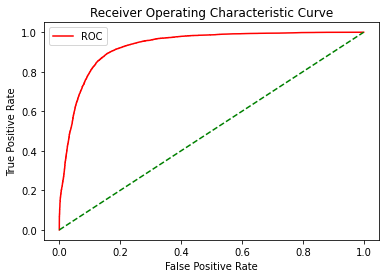

MSP AUROC score: 0.93029612


In [25]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=msp,
    id_dataloader=id_test_dataloader,
    ood_dataloader=ood_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores))
       
fper, tper, _ = roc_curve(test_y, ood_scores)
auroc_score = roc_auc_score(test_y, ood_scores)

plot_roc_curve(fper, tper)
print('MSP AUROC score:', auroc_score)

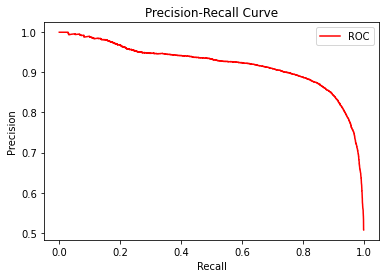

MSP AUPR score: 0.9186880167998135


In [26]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(test_y, ood_scores)
aupr_score = average_precision_score(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('MSP AUPR score:', aupr_score)

### OOD detection by Mahalanobis

In [27]:
from ood_with_vit.metrics.mahalanobis import Mahalanobis

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar10 = CIFAR10(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
id_train_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

mahalanobis = Mahalanobis(config, model, id_train_dataloader)

100%|██████████| 98/98 [01:02<00:00,  1.56it/s]


covariance norm: 23.098447184632178


  0%|          | 0/100 [00:00<?, ?it/s]

processing in-distribution samples...


  0%|          | 0/100 [00:00<?, ?it/s]

processing out-of-distribution samples...


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


id mean score: 182.6435 id variance: 8087.9224
ood mean score: 481.7878 ood variance: 24323.402


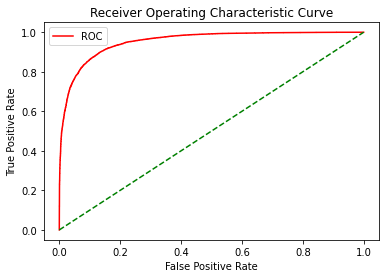

Mahalanobis AUROC score: 0.9535046


In [30]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=mahalanobis,
    id_dataloader=id_test_dataloader,
    ood_dataloader=ood_test_dataloader,
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))
       
fper, tper, _ = roc_curve(test_y, ood_scores)
auroc_score = roc_auc_score(test_y, ood_scores)

plot_roc_curve(fper, tper)
print('Mahalanobis AUROC score:', auroc_score)

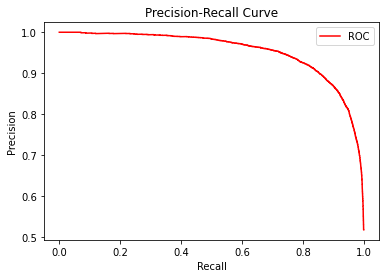

Mahalanobis AUPR score: 0.9541417526811801


In [29]:
precision, recall, _ = precision_recall_curve(test_y, ood_scores)
aupr_score = average_precision_score(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('Mahalanobis AUPR score:', aupr_score)

In [ ]:
from ood_with_vit.metrics.sml import SML

sml = SML(config, model, id_train_dataloader)

In [ ]:
test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=sml,
    id_dataloader=id_test_dataloader,
    ood_dataloader=ood_test_dataloader,
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))
       
fper, tper, _ = roc_curve(test_y, ood_scores)
auroc_score = roc_auc_score(test_y, ood_scores)

plot_roc_curve(fper, tper)
print('Mahalanobis AUROC score:', auroc_score)